In [1]:
import os
import requests
import io
import re
import pandas as pd
import emojis
import string
import seaborn as sns
import matplotlib.pyplot as plt
from ipyleaflet import Map, basemaps, Marker, Popup, MarkerCluster
from ipywidgets import HTML, widgets
from IPython.display import display, clear_output

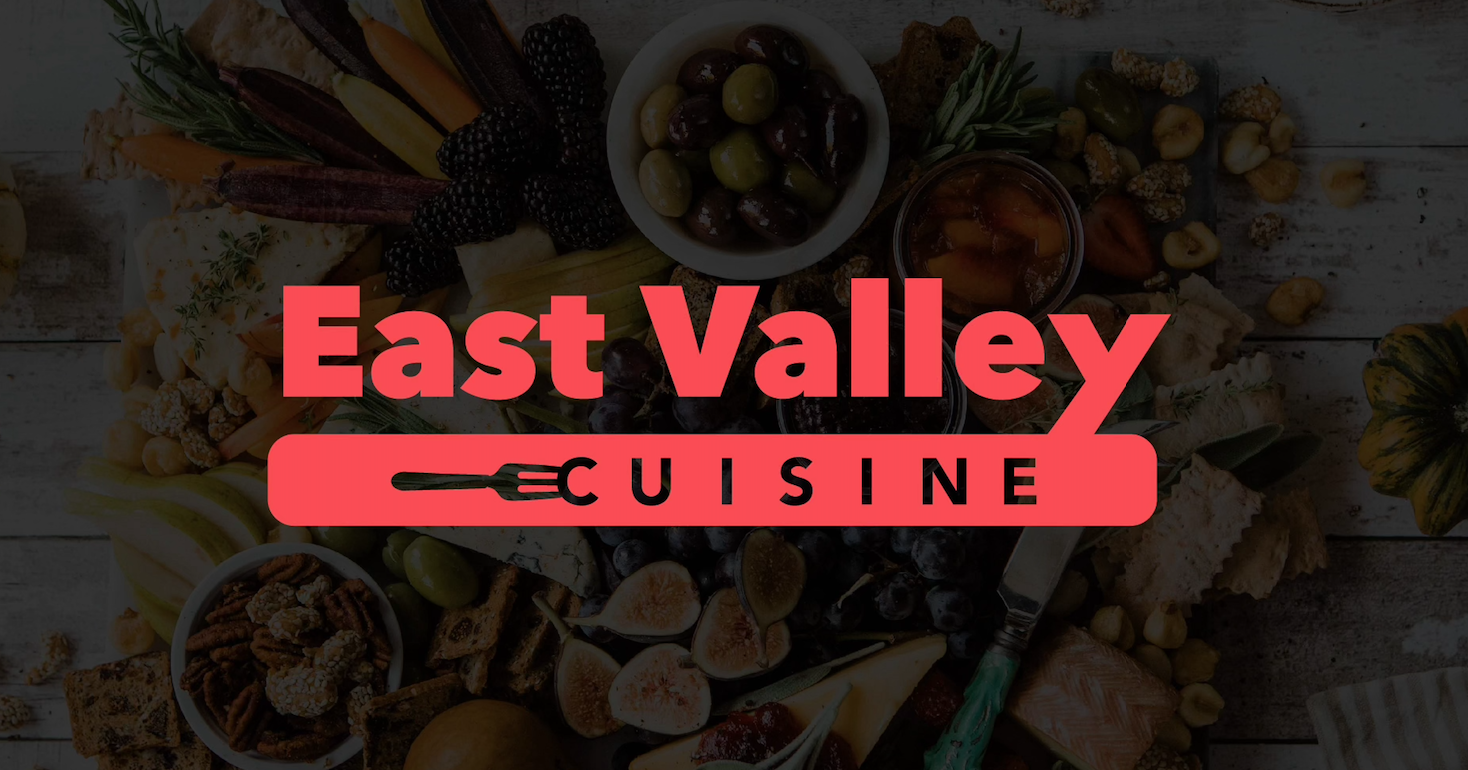

In [2]:
#!jupyter nbextension enable --py widgetsnbextension --sys-prefix
#!jupyter serverextension enable voila --sys-prefix

In [3]:
url = "https://raw.githubusercontent.com/laurakaneta/East_Valley_Reviews/main/East_Valley_Reviews_Data_Deidentified.csv"
downloaded = requests.get(url).content
East_Valley = pd.read_csv(io.StringIO(downloaded.decode('ISO-8859-1')))
#East_Valley

In [4]:
#East_Valley.info()

In [5]:
#East_Valley.columns

In [6]:
East_Valley_slimmed_down = East_Valley[['name', 'review_text', 'City']]

In [9]:
#East_Valley_slimmed_down[East_Valley_slimmed_down.review_text.isnull()]

In [10]:
East_Valley_narrowed = East_Valley_slimmed_down.dropna()

In [9]:
#print('Number of Reviews:', "\033[1m", f"{len(East_Valley_narrowed)}", "\033[0m")

Number of Reviews:  10401 


In [11]:
#print('Number of Establishments', '\n', 
#      'Gilbert:', "\033[1m", f"{East_Valley_narrowed[East_Valley_narrowed.City == 'Gilbert'].name.nunique(): >5}","\033[0m",'\n',
#     'Chandler:', "\033[1m", f"{East_Valley_narrowed[East_Valley_narrowed.City == 'Chandler'].name.nunique():>4}","\033[0m", '\n',
#      'Tempe:', "\033[1m", f"{East_Valley_narrowed[East_Valley_narrowed.City == 'Tempe'].name.nunique() :>7}","\033[0m", '\n',
#      "Mesa:", "\033[1m", f"{East_Valley_narrowed[East_Valley_narrowed.City == 'Mesa'].name.nunique() : >8}","\033[0m", '\n',
#     )

#print("\033[1m", "Total", f"{East_Valley_narrowed.name.nunique() :>9}", "\033[0m",) 

In [12]:
establishments = []
for food in East_Valley_narrowed.name.unique():
    establishments.append([food, len(East_Valley_narrowed[East_Valley_narrowed.name == food])])

In [13]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [14]:
East_Valley_narrowed_without_city = East_Valley_narrowed.drop("City", axis = 1)

In [15]:
East_Valley_grouped = pd.DataFrame(East_Valley_narrowed_without_city.groupby('name')['review_text'].apply(' '.join).reset_index())
review_data =East_Valley_grouped.review_text
#East_Valley_grouped

In [16]:
#review_data

In [17]:
#CountVectorizer preprocesses and tokenizes the data
cv_doc = CountVectorizer(stop_words = "english")
CountVectorizerReviews = cv_doc.fit_transform(review_data) #Count matrix
#CountVectorizerReviews.shape
#Each row is each invidual restaurant, and the columns represent unique words. So there are 12511 unique word

In [18]:
# TfidfTransformer "Transform a count matrix to a normalized tf or tf-idf representation" -sklearn
#TF stands for term frequency, and IDF stands for inverse document frequency. 
#The product of these two terms is the tf-idf weight of the word

#tf-idf scores 
tfidf_reviews=TfidfTransformer(smooth_idf=True,use_idf=True) 
tf_idf_vector= tfidf_reviews.fit_transform(CountVectorizerReviews)

In [19]:
df_idf = pd.DataFrame(tfidf_reviews.idf_, index=cv_doc.get_feature_names(),columns=["IDF weights"]) 
 
# sort ascending. The smaller the weight, the more common the word is across the board.
#df_idf.sort_values(by=['IDF weights'])

In [20]:
feature_names = cv_doc.get_feature_names()
#len(feature_names)

In [21]:
#get tfidf vector for first food establishment ('8282 Food') 
Food_One=tf_idf_vector[0] 
df = pd.DataFrame(Food_One.T.todense(), index=feature_names, columns=["tfidf"]) 
#df.sort_values(by=["tfidf"],ascending=False)

In [22]:
cos_sim = cosine_similarity(tf_idf_vector)
cos_sim_df = pd.DataFrame(cos_sim, columns = East_Valley_grouped.name, index = East_Valley_grouped.name)

In [23]:
#plt.figure(figsize=(20,10))
#plotting = sns.heatmap(cos_sim, cmap="YlGnBu")

In [24]:
#cos_sim_df["Top Cup Coffee House"].sort_values(ascending=False).head()

In [25]:
urlfood = "https://raw.githubusercontent.com/laurakaneta/East_Valley_Reviews/main/Food_City.csv"
download = requests.get(urlfood).content
Food_City = pd.read_csv(io.StringIO(download.decode('ISO-8859-1')))

In [26]:
cos_sim_df.index = sorted(Food_City.name)
#cos_sim_df

In [27]:
def recommendation(establishment):
    places = []
    food = []
    cos_sim_df1 = cos_sim_df[establishment].reset_index().copy()
    cos_sim_df_ordered = cos_sim_df1.sort_values(by = establishment, ascending=False)
    cos_sim_df_ordered = cos_sim_df_ordered.rename(columns = {'index': 'name'})
    for i in cos_sim_df_ordered.name[1:6]:
        print(i, ':',  Food_City[Food_City.name == i].City.item())
        places.append(Food_City[Food_City.name == i].Coordinates.item())
        food.append(Food_City[Food_City.name == i].name.item())
    
    m = Map(center = (33.3528, -111.7890), zoom = 10, min_zoom = 1, max_zoom = 20, 
            basemap=basemaps.Stamen.Terrain)


    
    marker1 = Marker(location=((float(places[0].split(',')[0])),(float(places[0].split(',')[1]))), draggable=True)
    marker2 = Marker(location=((float(places[1].split(',')[0])),(float(places[1].split(',')[1]))), draggable=True)        
    marker3 = Marker(location=((float(places[2].split(',')[0])),(float(places[2].split(',')[1]))), draggable=True)
    marker4 = Marker(location=((float(places[3].split(',')[0])),(float(places[3].split(',')[1]))), draggable=True)
    marker5 = Marker(location=((float(places[4].split(',')[0])),(float(places[4].split(',')[1]))), draggable=True)
    
    marker_cluster = MarkerCluster(
    markers=(marker1, marker2, marker3, marker4, marker5))
    
    m.add_layer(marker_cluster)

    
    
    
    message1 = HTML()
    message1.value = food[0]

    message2 = HTML()
    message2.value = food[1]

    message3 = HTML()
    message3.value = food[2]

    message4 = HTML()
    message4.value = food[3]

    message5 = HTML()
    message5.value = food[4]



    popup1 = Popup(
        location=((float(places[0].split(',')[0])),(float(places[0].split(',')[1]))),
        child=message1,
        close_button=True,
        auto_close=False,
        close_on_escape_key=False
    )
    m.add_layer(popup1)


    

    popup2 = Popup(
        location=((float(places[1].split(',')[0])),(float(places[1].split(',')[1]))),
        child=message2,
        close_button=True,
        auto_close=False,
        close_on_escape_key=False
    )
    m.add_layer(popup2)


    popup3 = Popup(
        location=((float(places[2].split(',')[0])),(float(places[2].split(',')[1]))),
        child=message3,
        close_button=True,
        auto_close=False,
        close_on_escape_key=False
    )
    m.add_layer(popup3)

    popup4 = Popup(
        location=((float(places[3].split(',')[0])),(float(places[3].split(',')[1]))),
        child=message4,
        close_button=True,
        auto_close=False,
        close_on_escape_key=False
    )
    m.add_layer(popup4)
    

    popup5 = Popup(
        location=((float(places[4].split(',')[0])),(float(places[4].split(',')[1]))),
        child=message5,
        close_button=True,
        auto_close=False,
        close_on_escape_key=False
    )
    m.add_layer(popup5)

    display(m)
    



In [28]:
#recommendation("Top Cup Coffee House")

# Top Five Recommended

#### Select a food establishment from the dropdown menu for the top five most similar locations in the East Valley.

In [29]:
drop_down_reviews = widgets.Dropdown(options = sorted(East_Valley_narrowed.name.unique()))
output_food = widgets.Output()
display(output_food)

def dropdown_food(food):
    with output_food:
        clear_output()
        recommendation(food.new)
  
            
drop_down_reviews.observe(dropdown_food, names = 'value')
display(drop_down_reviews)

Output()

Dropdown(options=('8282 Food', 'Aloha Kitchen', 'BlackBerry Cafe', 'Blue 32 Sports Grill', 'Board & Brew - Tem…

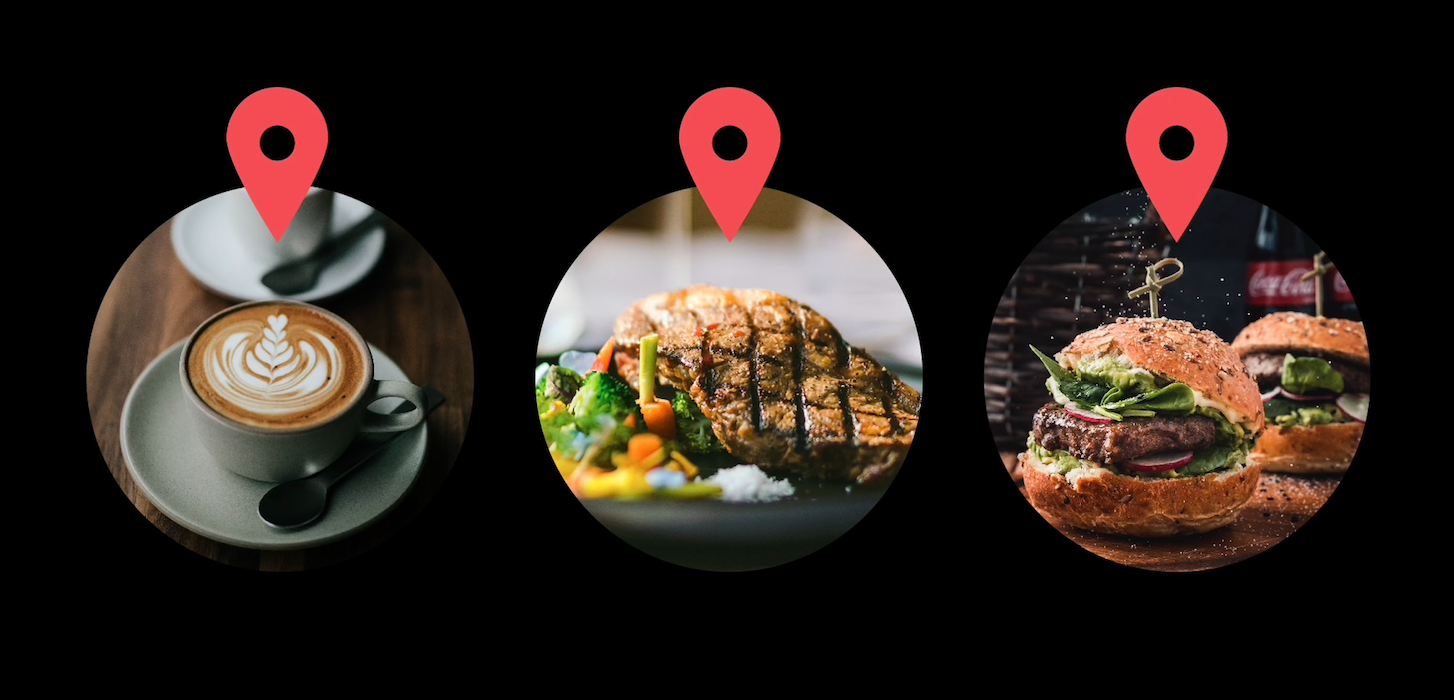